**Notes**

datanın stationary olması gerekiyor

outlier, lineer modellerde bozar

scaling neden yaparız

Rest Api develoment. deployment süreci: en son api'ye çevriliyor. 
    
Target encoding önemli (5 kategorinin üzerine çıkma durumlarında, overfit problemi olabilir doğru yapman lazım)
  
neural network bankada çok kullanılmıyor, explainability sıkıntısı oluyor.
  
Feature elemesi logistic regression ile? 

overfitting olduysa, train-test splitinde leakage var mı kontrol et

gridsearchte accuracy verme metric olarak, average precision score (scikitlearn)

#### Kredi Yaşam Döngüsü
 - Başvuru Süreci
     * Kredi Skoru (batma ihtimali - PD)
     * Fraud ihtimali (bir kişi krediyi alip ortadan kaybolur mu?)
     * Fiyatlama (kişiye özel faiz)
 - Ödeme süreci 
     * Kredi skorı
     * erken kapma
     * gecikme durumu (ödeme vaktinde yapılmadı)
         - 30 gün içinde döner mi
         - 90 gün içinde döner mi
     * batık durumu (NPL)
         - %x kadarini geri ödeme ihtimali
         - hukuk ekiplerine aksiyon önerisi
     * Ödemelerin tamamlanması
         - çapraz ürün satışı (recommendation)

#### Yapay Zeka Proje Akışı
  - İş birimi ile problemin tanımlanması
  - problemin formülize edilmesi
      * target belirlenmesi
      * popülasyonun belirlenmesi
      * model harici optimizasyon denklemi belirlenmesi
  - veri hazırlanması
      * PL/SQL
      * kullanılacak tabloların öğrenilmesi
      * feature engineering
      * verinin derlenmesi
  - modelleme aşaması
      * Python, Jupyter notebook
      * Adımlar
          - Data quality(feature'lar shift ediyor mu)
          - Exploratory analysis
          - Preprocessing (outlier, scaling, missing values)
          - Encoding (one-shot, ordinal, target)
          - Feature engineering (date features vs.)
          - Feature selection (SFS)
          - Hyperparameter tuning
          - Model evaluation (metrics)
          - Model explainability (shap)
          - Final model
   - Deployment
       * Rest API development(flask,fastapi)
       * Containerization (Docker)
       * CI/CD pipelines (Jenkins)
          
          
          
          
          
          
          

#### Credit Scoring Data Case Study
 
Bu calışmada kullanacağın data ve değişken açıklamaları ekli excel dosyasında: ‘CaseStudyData’.

Konumuz kredi başvuru skorlama (credit scoring) ve akış python ile geliştirilecek. İnternette bolca ornek 
bulabileceğin bir problem.

Bu calismani bir jupyter notebook olarak hazirlamani rica ediyoruz.
 
* Projede görmek istediğimiz temel adımlar;
    - Data analizi
    - Değişken analizi (dağılım, temel istatistikler, data anomalileri, vb.)
    - Outlier analysis, missing value imputation, variable normalization, encoding, etc.
    - Feature engineering/importance/selection
        * Hangi metotlarla öncelik hesaplanacak?
        * Hangi değişkenler kalacak, hangileri elenecek?
    - Alternatif algoritmaların belirlenmesi ve modellerin geliştirilmesi (Logistic Regression – sckit-learn, XGBoost, LightGBM, Random Forest, GAM, vb.)
    - Model sonuçlarının değerlendirilmesi (performans için hangi KPI lara bakılacak? sonuçların grafik gösterimleri, kalibrasyon vb.)
    - Geliştirmenin jupyter notebook olarak paylaşılması
    - Notebook dışında detay açıklama/anlatma ihtiyacı olursa, özet bir sunum/yazı şeklinde ek bir doküman da paylaşılabilir.

In [14]:
print("will I see this on jupyter notebook")

will I see this on jupyter notebook


# Credit Scoring Data Case

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score

from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [11]:
file_path = '/Users/Bora/Desktop/CaseStudyData.xlsx'
   
df = pd.read_excel(file_path, sheet_name=0)               # Data
variable_names = pd.read_excel(file_path, sheet_name=1)   # Variable Description

df = df.drop(columns=df.columns[0])

new_column_names = variable_names['Description'].tolist()
df.columns = new_column_names
df.rename(columns={'Good_Bad_Flag': 'Target'}, inplace=True)
df

,Target,CC Num of application_L1M,Worst Account Status All Credits,Any Legal Action YN,Existing Credit Card Previous Limit,LO Num of application_L6M,TS Last Legal Action,TS Oldest Open Credit Card,CC TS First Open Active Credit Card,Last Credit Decision,...,LO TS First Open Date,MO Number of months in 1 delay_L6M,MO Number of months in 3 or more delay_L6M,E Mail Given YN,OD_Pending Credit_YN,CC Number of months in 2 delay_L12M,Num Unpaid Cards L25M-L36M,Guarantee YN,Overridden_From_Final_Decline_YN,CC Existing Customers in L6M
0,0,0,L,Y,1750.0,1,36.0,86,2606,A,...,5.0,NaN,NaN,Y,N,NaN,0,N,N,Y
1,0,0,1,N,1300.0,12,NaN,13,406,R,...,15.0,NaN,NaN,Y,N,NaN,0,N,N,Y
2,0,0,0,N,0.0,0,NaN,274,8337,A,...,NaN,NaN,NaN,Y,N,NaN,0,N,N,N
3,1,0,L,Y,800.0,3,37.0,6,8,A,...,NaN,NaN,NaN,N,N,NaN,0,N,N,Y
4,0,0,1,N,6250.0,0,NaN,126,3833,A,...,NaN,0.0,NaN,Y,N,NaN,0,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34579,0,0,0,N,0.0,1,NaN,52,1589,A,...,NaN,NaN,NaN,Y,N,NaN,0,N,N,Y
34580,0,0,L,Y,NaN,7,37.0,5,0,NaN,...,NaN,NaN,NaN,N,N,0.0,0,N,N,NaN
34581,0,0,0,N,0.0,1,NaN,30,909,A,...,NaN,NaN,NaN,Y,N,NaN,0,N,N,Y
34582,0,0,1,N,NaN,10,NaN,150,4571,NaN,...,NaN,NaN,NaN,N,N,NaN,0,Y,N,NaN


**Target:** Good_Bad_Flag, hedef değişken, kredi başvurusunun onaylanıp onaylanmadığını gösteriyor (1: Onaylı, 0: Reddedilmiş).

**Var_1, Var_2, vb.:** Başvuru sahiplerinin kredi skorlarını etkileyebilecek çeşitli özellikleri temsil ediyor.

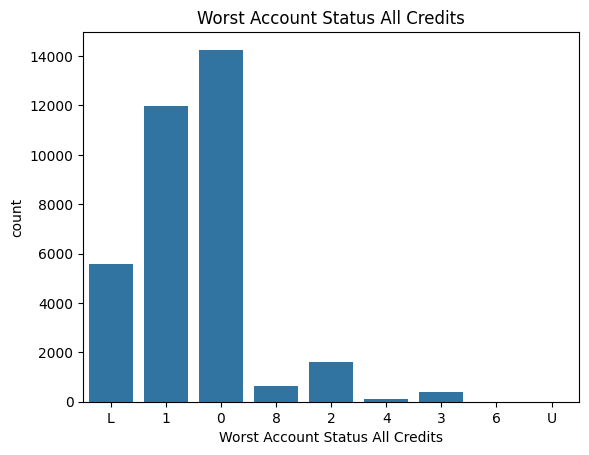

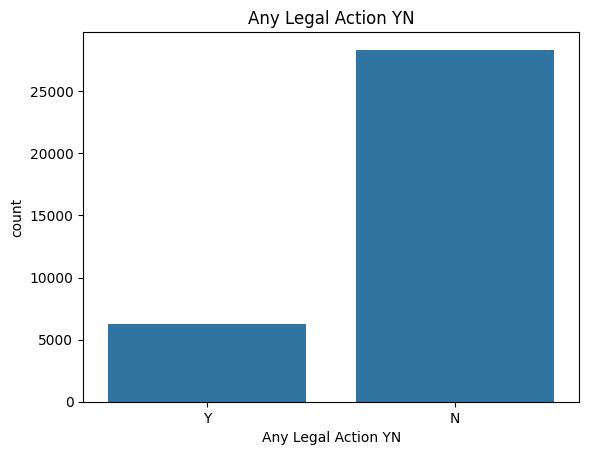

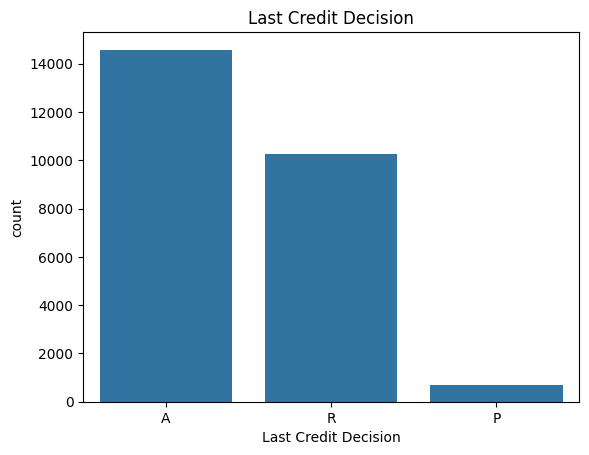

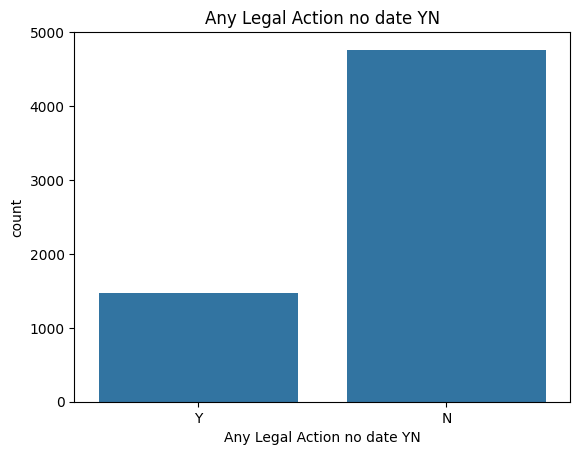

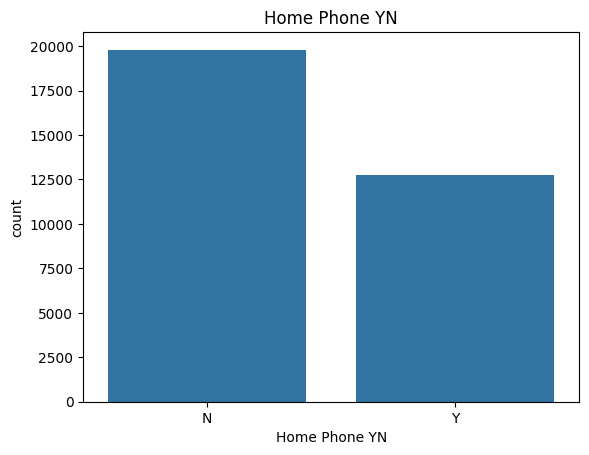

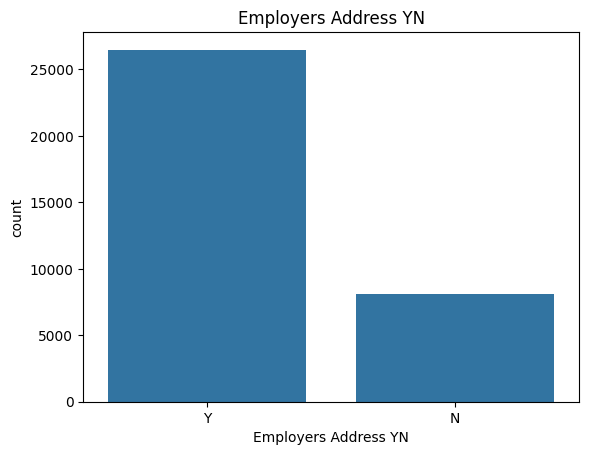

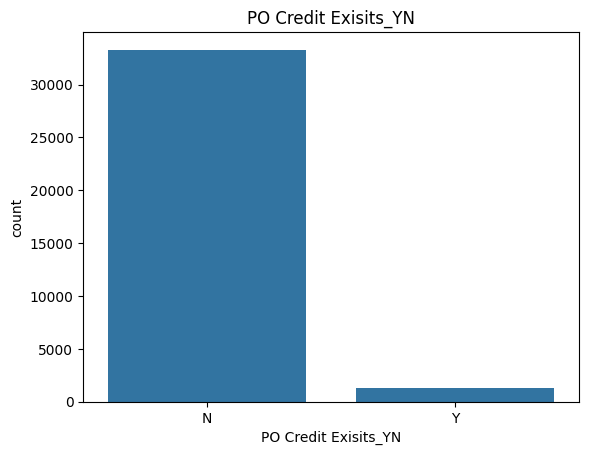

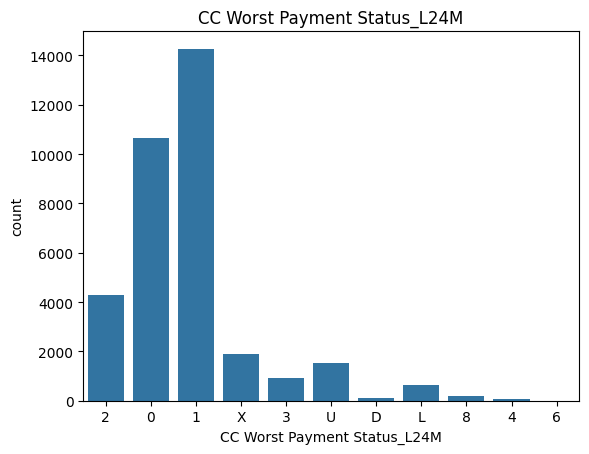

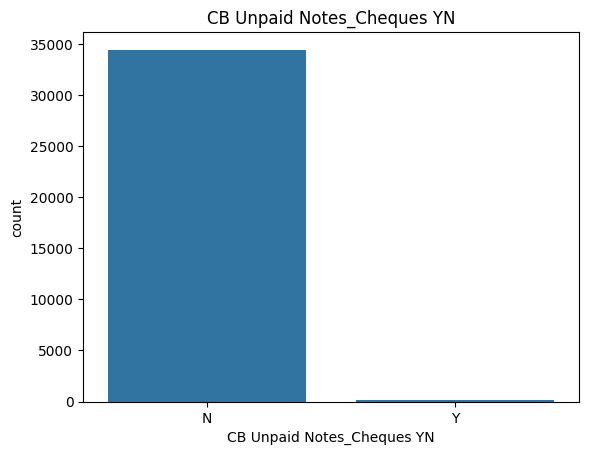

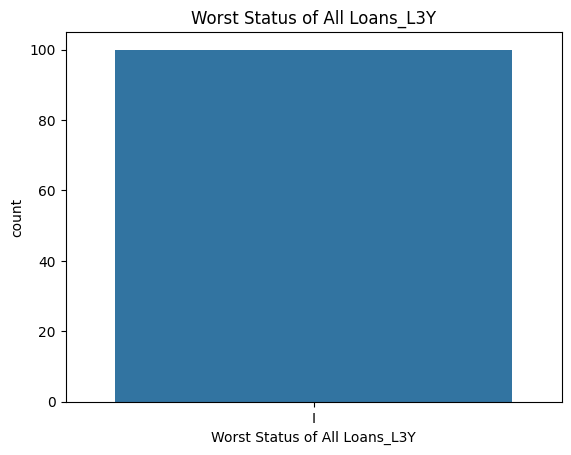

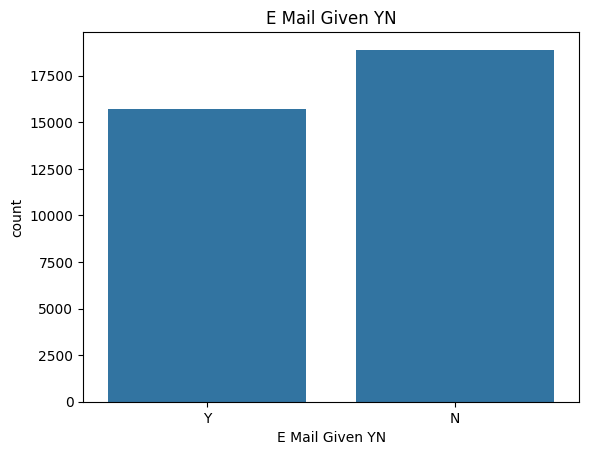

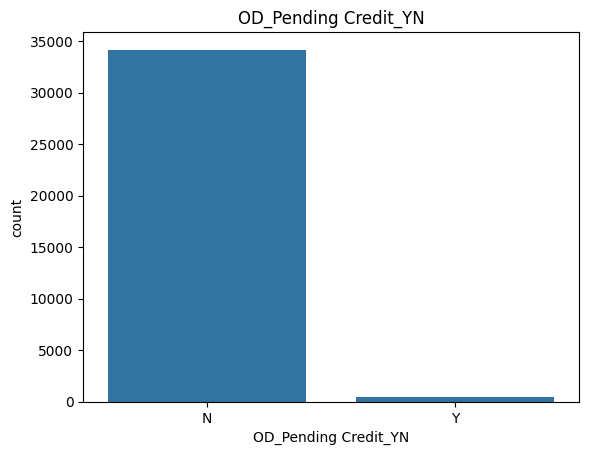

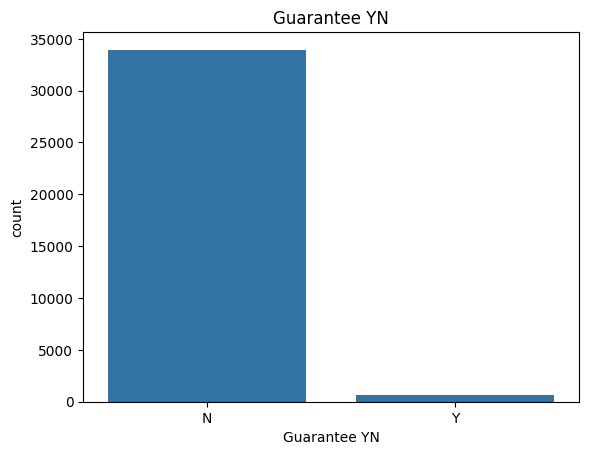

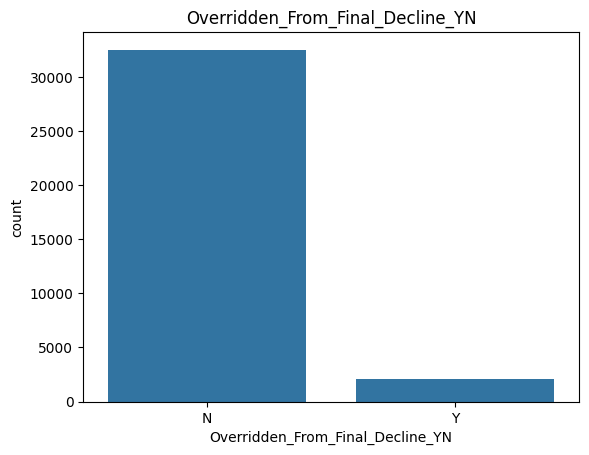

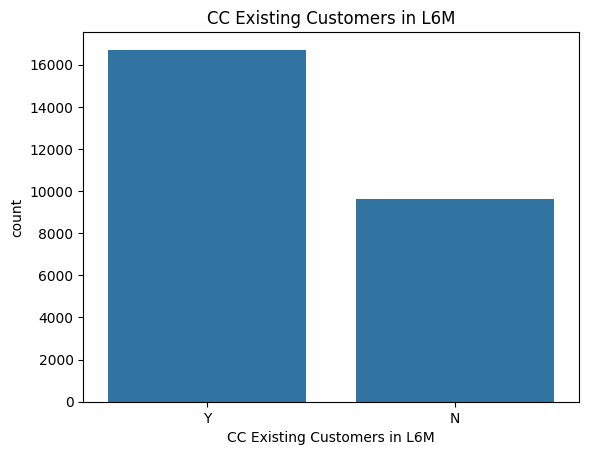

In [12]:
# Kategorik değişkenler
for col in df.select_dtypes(include=['object']).columns:
    sns.countplot(x=col, data=df)
    plt.title(f'{col}')
    plt.show()

In [4]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_values, missing_percentage

(Target                                             0
 CC Num of application_L1M                          0
 Worst Account Status All Credits                   0
 Any Legal Action YN                                0
 Existing Credit Card Previous Limit             8471
 LO Num of application_L6M                          0
 TS Last Legal Action                           29034
 TS Oldest Open Credit Card                         0
 CC TS First Open Active Credit Card                0
 Last Credit Decision                            9048
 Total Assets_3                                    15
 Any Legal Action no date YN                    28346
 TS Last Closed good account                     4032
 CC Num of application_L6M                          0
 Home Phone YN                                   2052
 Employers Address YN                               0
 AMC_Transfer_Outstanding                       16235
 Existing Customer Limit                         8226
 CC Total Payment of all Cre

In [5]:
# %90'dan fazla eksik veriye sahip sütunlar
columns_to_drop = missing_percentage[missing_percentage > 90].index

print("Drop'lanan sütunlar:")
print(columns_to_drop.tolist())

# %90'dan fazla eksik veriye sahip sütunları drop
df_cleaned = df.drop(columns=columns_to_drop)

# Sayısal ve kategorik değişkenlere göre doldurma
for column in df_cleaned.columns: 
    if df_cleaned[column].dtype == 'object':                                 # Kategorik değişkenler için mod
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:                                                                    # Sayısal değişkenler için mean, median daha iyi olabilir, outliar varsa mean sıkıntı
        df_cleaned[column].fillna(df_cleaned[column].mean(), inplace=True)

cleaned_missing_values = df_cleaned.isnull().sum()
cleaned_missing_values

Drop'lanan sütunlar:
['OD Number of months in 2 delay_L24M', 'Worst Status of All Loans_L3Y', 'MO Number of months in 3 or more delay_L24M', 'MO Number of months in 1 delay_L6M', 'MO Number of months in 3 or more delay_L6M', 'CC Number of months in 2 delay_L12M']


Target                                  0
CC Num of application_L1M               0
Worst Account Status All Credits        0
Any Legal Action YN                     0
Existing Credit Card Previous Limit     0
LO Num of application_L6M               0
TS Last Legal Action                    0
TS Oldest Open Credit Card              0
CC TS First Open Active Credit Card     0
Last Credit Decision                    0
Total Assets_3                          0
Any Legal Action no date YN             0
TS Last Closed good account             0
CC Num of application_L6M               0
Home Phone YN                           0
Employers Address YN                    0
AMC_Transfer_Outstanding                0
Existing Customer Limit                 0
CC Total Payment of all Credit cards    0
OD Tot Outstanding Balance YTL          0
Residential Status                      0
Time in Employment                      0
CC Number of months in 1 delay_L12M     0
Last Declared Monthly Income_L3M  

In [6]:
# Categorical Data için One-hot encoding
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

df_encoded.head()

# 5/6 dan büyük kategoriler çok ayrılırsa %lik değeri az olan kategorileri birleştirebiliyoruz. 
# 5'den az olanlarda one-hot ile devam, 5den fazla (20 kategoriye ayrılmışları) target encode olarak yap.
# target encoding cross-val mantığı ile
# one-hot dışındakilerde train-test'i öne çek. impute'tan önce train-test split yap.

,Target,CC Num of application_L1M,Existing Credit Card Previous Limit,LO Num of application_L6M,TS Last Legal Action,TS Oldest Open Credit Card,CC TS First Open Active Credit Card,Total Assets_3,TS Last Closed good account,CC Num of application_L6M,...,CC Worst Payment Status_L24M_D,CC Worst Payment Status_L24M_L,CC Worst Payment Status_L24M_U,CC Worst Payment Status_L24M_X,CB Unpaid Notes_Cheques YN_Y,E Mail Given YN_Y,OD_Pending Credit_YN_Y,Guarantee YN_Y,Overridden_From_Final_Decline_YN_Y,CC Existing Customers in L6M_Y
0,0,0,1750.0,1,36.000000,86,2606,888.0,4.0,0,...,False,False,False,False,False,True,False,False,False,True
1,0,0,1300.0,12,31.411532,13,406,20.0,4.0,0,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0.0,0,31.411532,274,8337,511.0,0.0,0,...,False,False,False,False,False,True,False,False,False,False
3,1,0,800.0,3,37.000000,6,8,0.0,45.0,0,...,False,False,False,True,False,False,False,False,False,True
4,0,0,6250.0,0,31.411532,126,3833,32.0,8.0,0,...,False,False,False,False,False,True,False,False,False,False


### Train-Test Split ve Scaling

In [7]:
X = df_encoded.drop('Target', axis=1)
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)                                # Data leakage'ı önlemek için sadece train datası

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)       #xgboost'a sokulcak veriyi impute etmene veya scalelemene gerek yok.

In [8]:
# Sınıf dağılımı
train_class_distribution = pd.Series(y_train).value_counts(normalize=True)
test_class_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Train sınıf dağılımı:")
print(train_class_distribution)

print("\nTest sınıf dağılımı:")
print(test_class_distribution)

Train sınıf dağılımı:
Target
0    0.953486
1    0.046514
Name: proportion, dtype: float64

Test sınıf dağılımı:
Target
0    0.949595
1    0.050405
Name: proportion, dtype: float64


In [9]:
# SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Orijinal veri setindeki sınıf dağılımı:")
print(pd.Series(y_train).value_counts())

print("\nSMOTE sonrası sınıf dağılımı:")
print(pd.Series(y_train_smote).value_counts())

Orijinal veri setindeki sınıf dağılımı:
Target
0    23082
1     1126
Name: count, dtype: int64

SMOTE sonrası sınıf dağılımı:
Target
0    23082
1    23082
Name: count, dtype: int64


### Logistic Regression ile Feature Analizi

In [10]:
# Lasso
log_reg_lasso = LogisticRegression(class_weight='balanced',penalty='l1', solver='liblinear', random_state=42)  #‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories.
log_reg_lasso.fit(X_train_scaled, y_train)

coefficients = log_reg_lasso.coef_[0]

# Sıfır olan katsayılar 
zero_features = X_train.columns[np.where(coefficients == 0)]
print("\nÖnemsiz olan ve modelden çıkarılan özellikler:")
print(zero_features.tolist())


Önemsiz olan ve modelden çıkarılan özellikler:
['Worst Account Status All Credits_8', 'CC Worst Payment Status_L24M_6']


In [11]:
# Sadece sıfır olmayan özelliklerle veri setini yeniden oluşturma
X_train_selected = X_train_scaled[:, np.where(coefficients != 0)[0]]
X_test_selected = X_test_scaled[:, np.where(coefficients != 0)[0]]

#coef'lere göre sıralayabiliriz, sadece 0 atmak yerine.

In [51]:
def evaluate_model_performance(y_test, y_pred, y_pred_proba, model_name="Model"):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    print(f"{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    print("\nClassification Report:")
    print(class_report)

In [18]:
def plot_model_performance(y_test, y_pred_proba, model_name="Model"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(18, 5))

    # ROC Curve plot
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")

    # Precision-Recall Curve plot
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')

    # Calibration Curve plot
    plt.subplot(1, 3, 3)
    plt.plot(prob_pred, prob_true, marker='o', color='b', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve: {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Logistic Regression

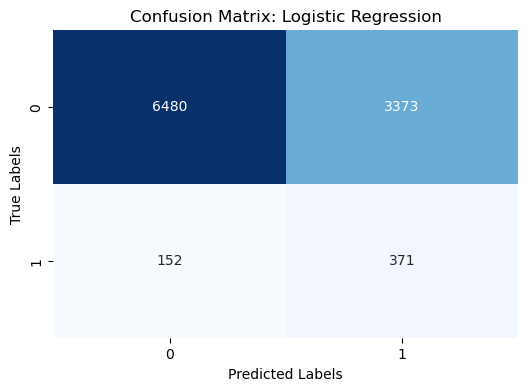

Logistic Regression Model Performance:
Accuracy: 0.66
ROC-AUC: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      9853
           1       0.10      0.71      0.17       523

    accuracy                           0.66     10376
   macro avg       0.54      0.68      0.48     10376
weighted avg       0.93      0.66      0.76     10376



In [53]:
log_reg_selected = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_selected.fit(X_train_selected, y_train)

y_pred_lr = log_reg_selected.predict(X_test_selected)
y_pred_proba_lr = log_reg_selected.predict_proba(X_test_selected)[:, 1]

evaluate_model_performance(y_test, y_pred_lr, y_pred_proba_lr, model_name="Logistic Regression")

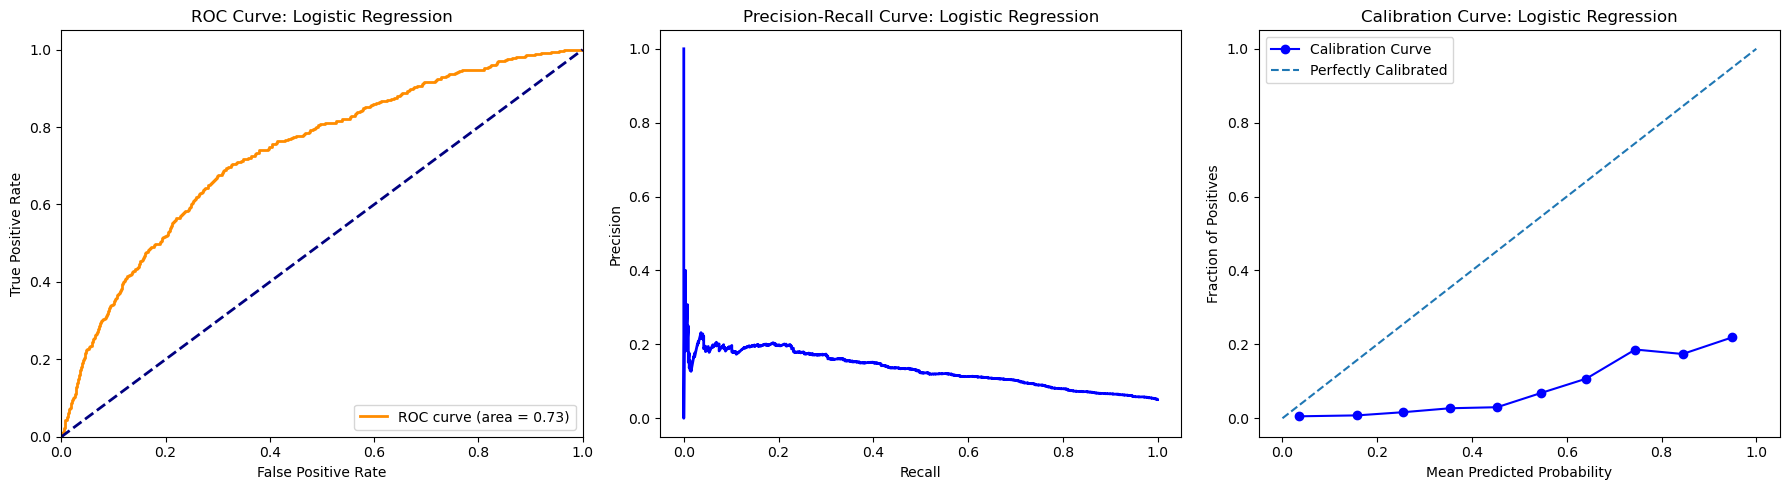

In [54]:
plot_model_performance(y_test, y_pred_proba_lr, model_name="Logistic Regression")

### Random Forest

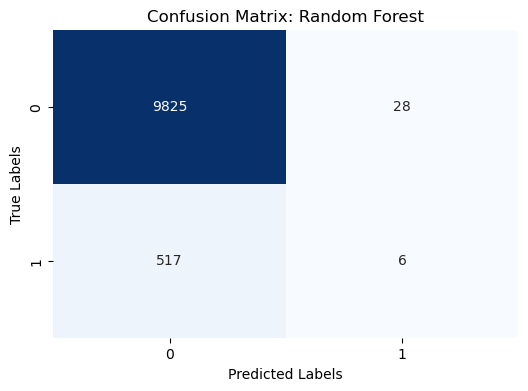

Random Forest Model Performance:
Accuracy: 0.95
ROC-AUC: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9853
           1       0.18      0.01      0.02       523

    accuracy                           0.95     10376
   macro avg       0.56      0.50      0.50     10376
weighted avg       0.91      0.95      0.93     10376



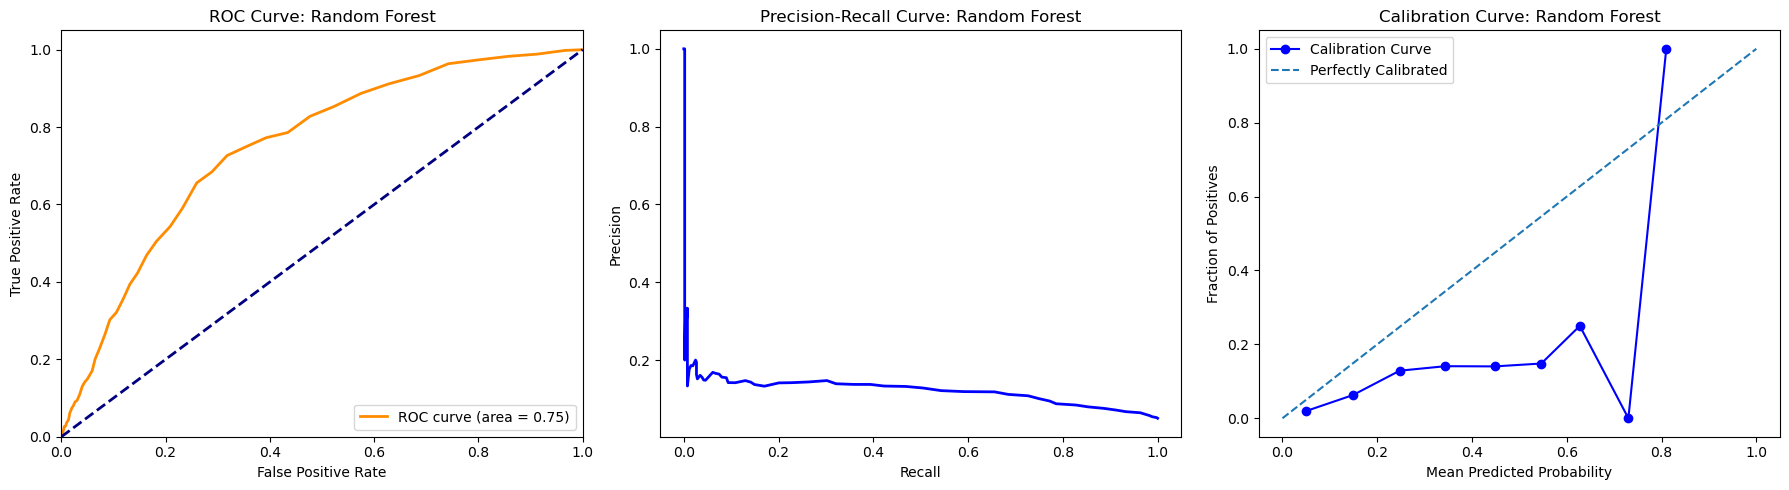

In [60]:
rf_model = RandomForestClassifier(class_weight="balanced")

rf_model.fit(X_train_smote, y_train_smote)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred_rf, y_pred_proba_rf, model_name="Random Forest")
plot_model_performance(y_test, y_pred_proba_rf, model_name="Random Forest")

### XGBoost Modeli

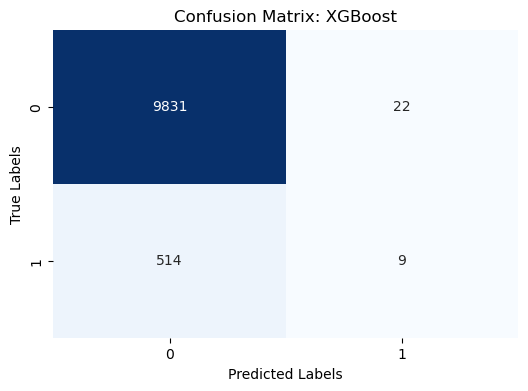

XGBoost Model Performance:
Accuracy: 0.95
ROC-AUC: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9853
           1       0.29      0.02      0.03       523

    accuracy                           0.95     10376
   macro avg       0.62      0.51      0.50     10376
weighted avg       0.92      0.95      0.93     10376



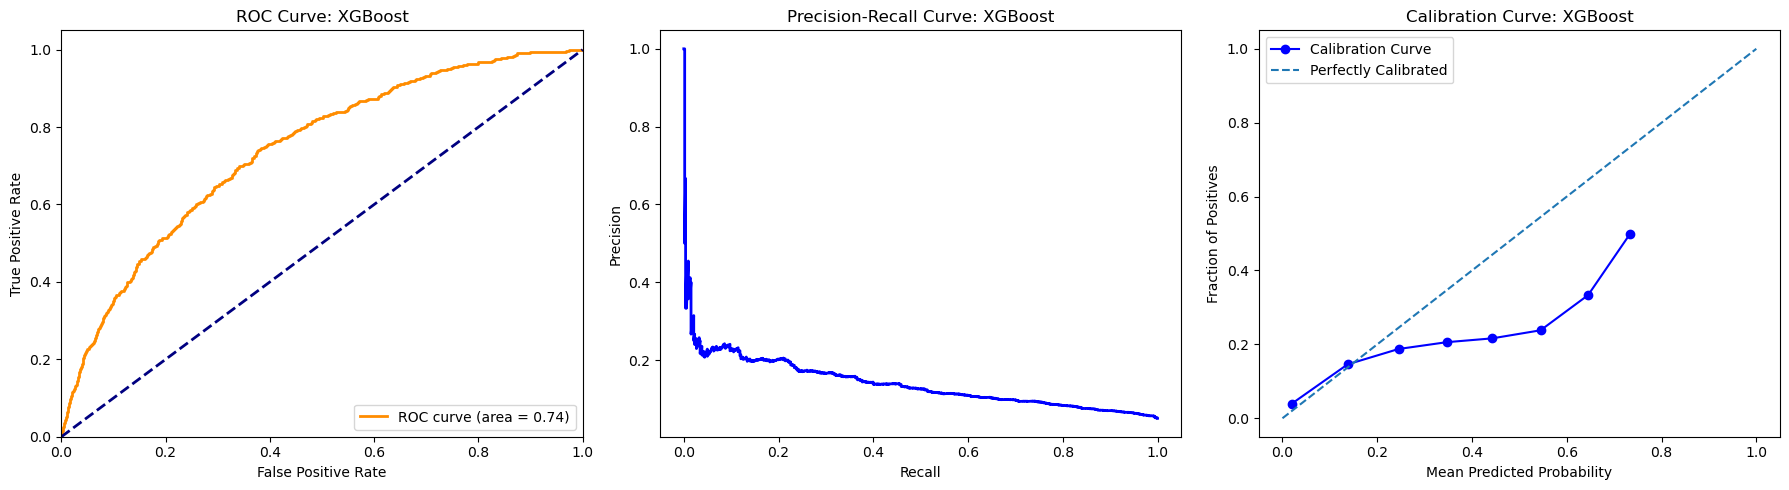

In [67]:
xgb_model = XGBClassifier(tree_method='exact') #class weight i elle gir. RF ile aynı problemler. maxdepth büyük olabilir

xgb_model.fit(X_train_selected, y_train)

y_pred_xgb = xgb_model.predict(X_test_selected)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

evaluate_model_performance(y_test, y_pred_xgb, y_pred_proba_xgb, model_name="XGBoost")
plot_model_performance(y_test, y_pred_proba_xgb, model_name="XGBoost")

### LightGBM

In [32]:
lgb_train_data = lgb.Dataset(X_train_scaled, label=y_train)
lgb_test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=lgb_train_data)

params = {
    'objective': 'binary',       # Binary classification problemi
    'metric': 'binary_logloss',  
    'boosting': 'gbdt',       # Gradient boosting ile modelleme
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 31,       #?  
    'feature_fraction': 0.9,  # Her iterasyonda kullanılacak özellik oranı
    'bagging_fraction': 0.8,  # Her iterasyonda kullanılacak veri oranı
    'bagging_freq': 5,        
    'verbose': -1  
}

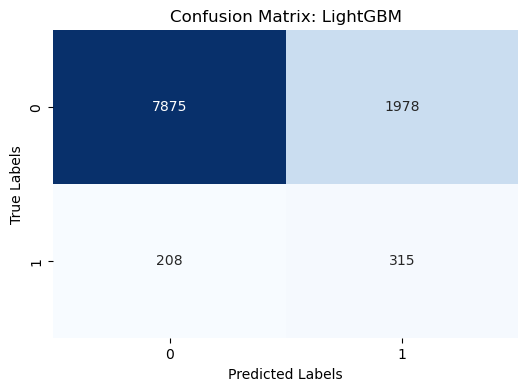

LightGBM Model Performance:
Accuracy: 0.79
ROC-AUC: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      9853
           1       0.14      0.60      0.22       523

    accuracy                           0.79     10376
   macro avg       0.56      0.70      0.55     10376
weighted avg       0.93      0.79      0.85     10376



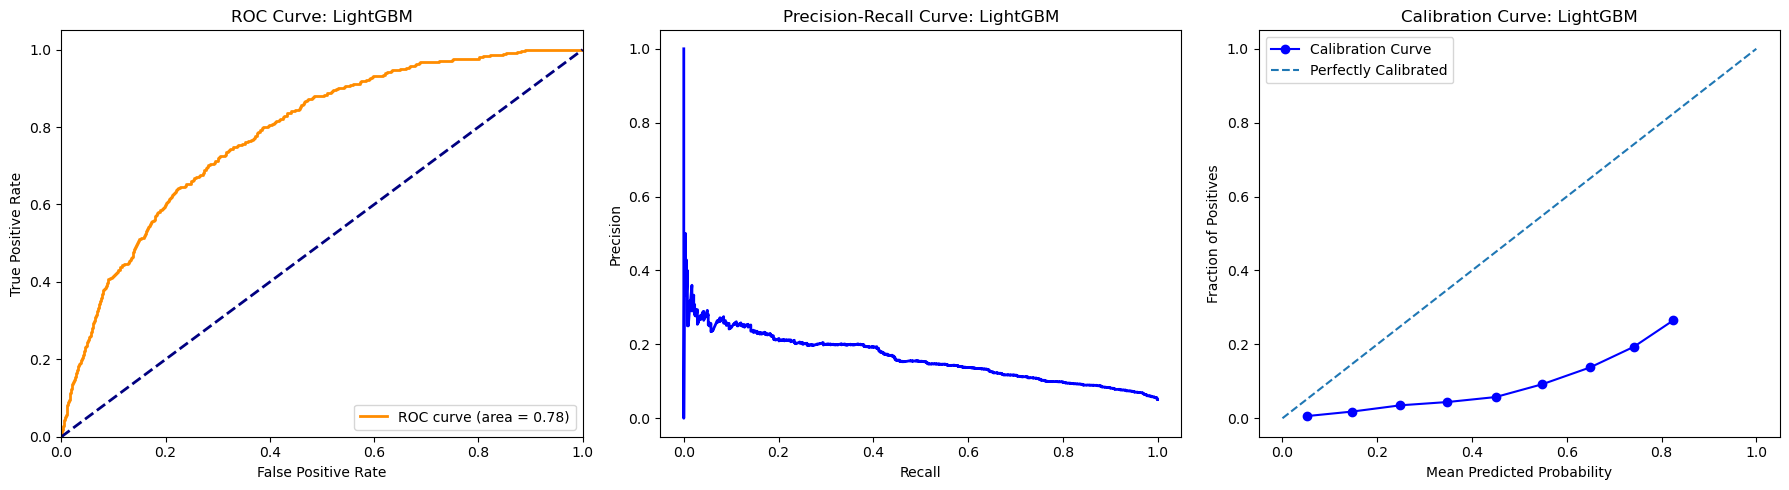

In [61]:
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=100, valid_sets=[lgb_train_data, lgb_test_data])

y_pred_proba_lgb = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)  # Olasılık tahminleri
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)  

evaluate_model_performance(y_test, y_pred_lgb, y_pred_proba_lgb, model_name="LightGBM")
plot_model_performance(y_test, y_pred_proba_lgb, model_name="LightGBM")

### Modellerin Performansları

In [62]:
print("Logistic Regression - Accuracy:", accuracy_selected, "ROC-AUC:", roc_auc_selected)
print("Random Forest - Accuracy:", accuracy_rf, "ROC-AUC:", roc_auc_rf)
print("XGBoost - Accuracy:", accuracy_xgb, "ROC-AUC:", roc_auc_xgb)
print("LightGBM - Accuracy:", accuracy_lgb, "ROC-AUC:", roc_auc_lgb)

Logistic Regression - Accuracy: 0.6831148804934464 ROC-AUC: 0.7557143547432148
Random Forest - Accuracy: 0.9475713184271396 ROC-AUC: 0.7466900143388887
XGBoost - Accuracy: 0.9491133384734002 ROC-AUC: 0.7517957570939076
LightGBM - Accuracy: 0.8287393986121819 ROC-AUC: 0.7549464702833371


### LightGBM Feature Elemesi

[LightGBM] [Info] Number of positive: 1126, number of negative: 23082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4820
[LightGBM] [Info] Number of data points in the train set: 24208, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.046514 -> initscore=-3.020382
[LightGBM] [Info] Start training from score -3.020382


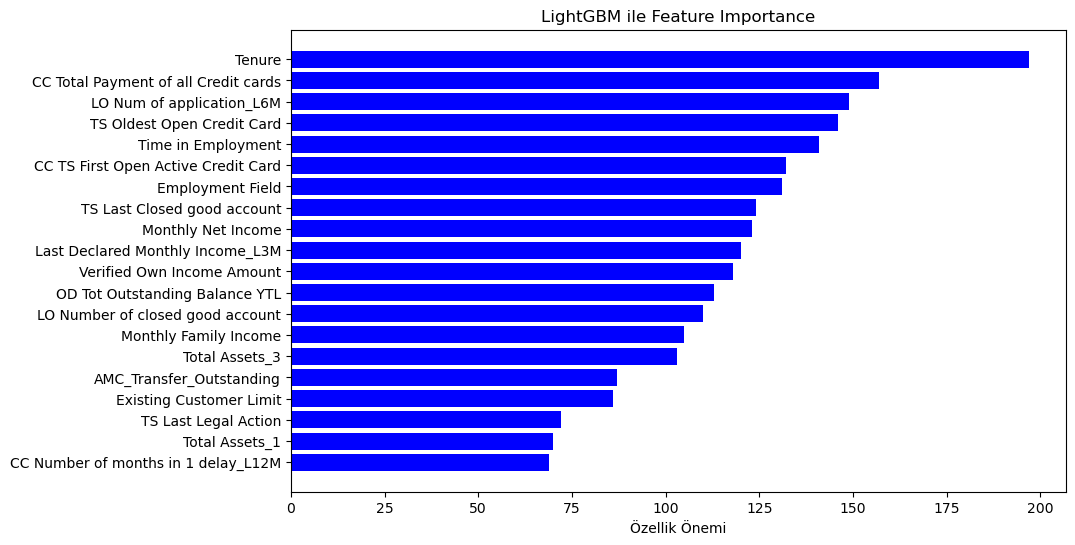

                                 Feature  Importance
19                                Tenure         197
11  CC Total Payment of all Credit cards         157
2              LO Num of application_L6M         149
4             TS Oldest Open Credit Card         146
14                    Time in Employment         141
5    CC TS First Open Active Credit Card         132
18                      Employment Field         131
7            TS Last Closed good account         124
17                    Monthly Net Income         123
16      Last Declared Monthly Income_L3M         120
23            Verified Own Income Amount         118
12        OD Tot Outstanding Balance YTL         113
26      LO Number of closed good account         110
20                 Monthly Family Income         105
6                         Total Assets_3         103
9               AMC_Transfer_Outstanding          87
10               Existing Customer Limit          86
3                   TS Last Legal Action      

In [36]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

feature_importances = lgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# İlk 20 özellik
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='b')
plt.xlabel("Özellik Önemi")
plt.title("LightGBM ile Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print(importance_df.head(60))

In [37]:
selected_features = ['Tenure', 'CC Total Payment of all Credit cards', 'TS Oldest Open Credit Card',
                     'LO Num of application_L6M', 'Verified Own Income Amount', 'Last Declared Monthly Income_L3M',
                     'TS Last Closed good account', 'Employment Field', 'Monthly Family Income', 'Time in Employment',
                     'CC TS First Open Active Credit Card', 'AMC_Transfer_Outstanding', 'Monthly Net Income',
                     'Total Assets_3', 'OD Tot Outstanding Balance YTL', 'LO Number of closed good account',
                     'Existing Customer Limit', 'CC Number of months in 1 delay_L12M', 'Existing Credit Card Previous Limit',
                     'LO TS First Open Date', 'TS Last Legal Action', 'Total Assets_1', 'Residential Status', 
                     'LO Num of open accounts_L12M', 'CC Num of application_L6M', 'Existing Overdraft Limit']

### LightGBM 2. Model

[LightGBM] [Info] Number of positive: 1126, number of negative: 23082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4243
[LightGBM] [Info] Number of data points in the train set: 24208, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.046514 -> initscore=-3.020382
[LightGBM] [Info] Start training from score -3.020382


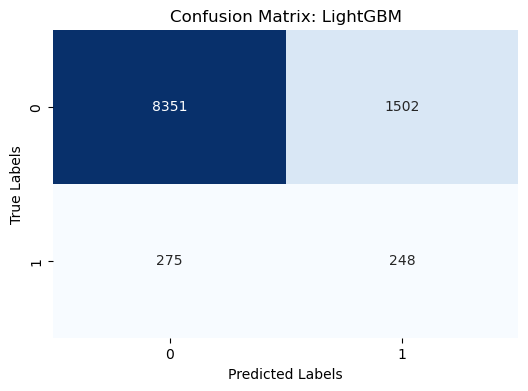

LightGBM Model Performance:
Accuracy: 0.83
ROC-AUC: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      9853
           1       0.14      0.47      0.22       523

    accuracy                           0.83     10376
   macro avg       0.55      0.66      0.56     10376
weighted avg       0.93      0.83      0.87     10376



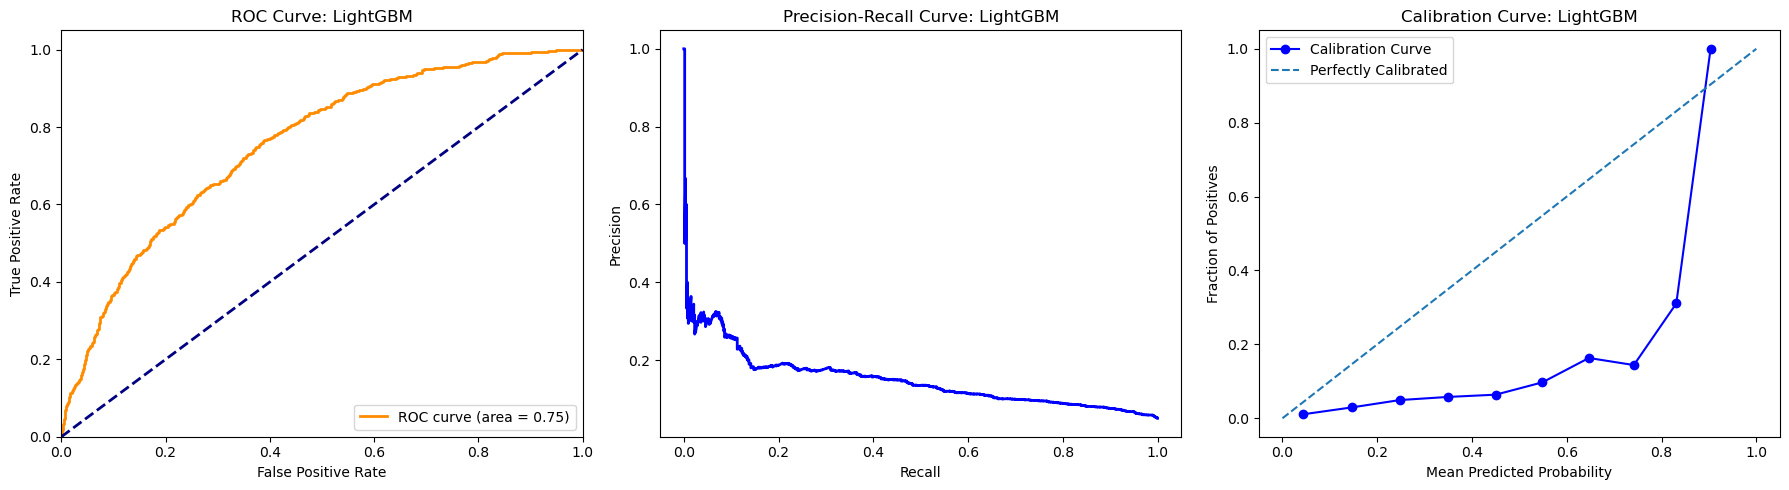

In [63]:
X_train_selected = X_train_scaled[:, [list(X_train.columns).index(f) for f in selected_features]]
X_test_selected = X_test_scaled[:, [list(X_test.columns).index(f) for f in selected_features]]

lgb_model2 = LGBMClassifier(is_unbalance=True, random_state=42)
lgb_model2.fit(X_train_selected, y_train)

y_pred_lgb2 = lgb_model2.predict(X_test_selected)
y_pred_proba_lgb2 = lgb_model2.predict_proba(X_test_selected)[:, 1]

evaluate_model_performance(y_test, y_pred_lgb2, y_pred_proba_lgb2, model_name="LightGBM")
plot_model_performance(y_test, y_pred_proba_lgb2, model_name="LightGBM")

/Users/bora/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


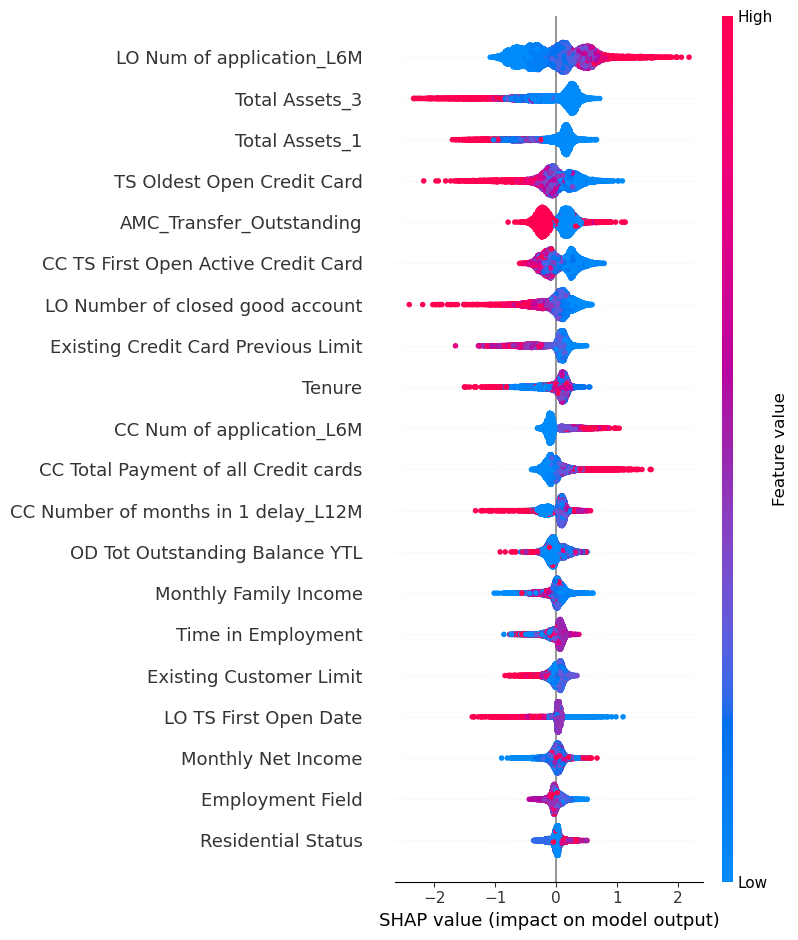

In [66]:
import shap

explainer = shap.TreeExplainer(lgb_model2)
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features)

korelasyonları bulup bazılarını eleyebiliriz.

train_test spliti bütün processlerin önüne at

one hot a train mi test mi diye flag ekle. getdummies i datasete ekle 

metriklerde f1, pr auc önemli accuracy en önemsiz. **sfs** 'e detaylı bak

importance a göre bölmek yerine performansa göre seç

parametreler (random forest en az oynicağımız, maxdepth falan olabilir)

5fold cross-val yapıp modelleri fit edip feature importanceları kaydet.

importanceların ortalaması, hepsinde 0 gelenler atılabilir. 

korelasyonlara göre bi temizlik, importance a bakmadan önce

ağaç modellerinde çok yüksek depth vermeyebiliriz. leaf sizeları büyütebiliriz, yüksek depth

cross val yaparken train score una da cross val score una bakmak kadar önemli. yakın olmalı.
traini de validation ı da printle. ikisi yakınsa test de onlar gibi olur == overfit olmamış.

shap'ın summary plot dışındaki plotlara bak.

gridsearchte accuracy verme metric olarak, average precision score (scikitlearn)

5/6 dan büyük kategoriler çok ayrılırsa %lik değeri az olan kategorileri birleştirebiliyoruz. 

5'den az olanlarda one-hot ile devam, 5den fazla (20 kategoriye ayrılmışları) target encode olarak yap.

target encoding cross-val mantığı ile

one-hot dışındakilerde train-test'i öne çek. impute'tan önce train-test split yap.